<a href="https://colab.research.google.com/github/jiahfong/incoherent-thoughts/blob/develop/Information_Condensing_Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Condensing Active Learning

# Introduction

Acquisition functions usually use model predictions/point locations (i.e. input features or learned representation space) to decide which points will improve model accuracy.
> IDEA: does latent disentanglement + distance metric work well? Find latent representations with greatest distance according to some distance metric

**GOAL**: develop and active learning acquisition function to select points that maximise the _eventual test accuracy_. This minimises the uncertainty on the unlabelled set.
> Conspicuously did not mention the speed at which it reaches the desired test accuracy?

* Selecting points that maximise MI between model params and labels doesn’t always minimise the model’s uncertainty on the unlabelled pool. Paper will demonstrate this point
* Instead, ICAL searches for the batch that maximises statistical dependency between the model’s predictions on the batch (B) and the model’s predictions on the unlabelled pool (instead of model params).
* Greedy algorithm employed to search for such a batch B (cf. feature selection)
* HSIC instead of MI as MI is hard to approximate using just samples (Song & Ernon 2019)
* HSIC is also differentiable, applicable in areas where MI would be difficult to make work.

# Related work

## Bayesian active learning by disagreement (BALD)
MI between unlabelled labels and model parameters. Turns out to be the points where the models are individually confident but are disagreeing with one another.

## Guo & Schuurmans (2008)
Find a batch such that the post-acquisition model is confident on the training set and has low uncertainty on the unlabelled dataset. This implies retraining the model for every candidate batch (read: exponential!) and is infeasible for large neural nets (method was mainly used for logistic regression)

## BMDR
Selects points that are close to the decision boundary while maintaining the overall sample distribution. The overall sample distribution is measured using maximum mean discrepancy (MMD) on *input features* between candidate batch and the set of all points (low MMD implies more representative batch). This method requires a decision boundary to work.

## BMAL
Selects a batch such that the Fisher information matrix between the batch and the
unlabelled pool is as close as possible. Note, this matrix is quadratic in the number of parameters, thus infeasible for NNs.

## Filtered Active Subset Selection
1. Pick a subset of points $\mathcal{B'}$ from the unlabelled pool where the model is most uncertain. Uncertainty is quantified using entropy in this case: $H(y|x, D_{train})$. Recall, entropy is low if the models are disagreeing with each other (first term in BALD).
2. Select a subset of points in `1.` that are representative as a whole (similar to ICAL in this regard) which favours points that can represent diversity of the set in `1.`. In other words, find $\mathcal{B}$ such that $f(\mathcal{B}) = \displaystyle\sum_{y\in\mathcal{Y}}\displaystyle\sum_{i\in V^y}\text{max}_{s\in \mathcal{B} \cap V^y}w(i, s)$ where:
    - $V^y$ is the set of points in $\mathcal{B'}$ that has predicted label $y$. ($V^y \subseteq \mathcal{B}'$)
    - $w(i, s)$ is a similarity function (e.g. $w(i, s) = d - ||x_i - x_s||^2_2$ where $d$ is the maximum possible distance between any two points)


## BatchBALD
Extending BALD to account for acquisition size of > 1. Eliminates overcounting in BALD when candidate batch size is > 1.

## Bayesian Batch Active Learning as Sparse Subset Approximation
Adapts Bayesian Coreset approach. This approach changes the batch size for every acquisition.

## DeepFool
Uses the concept of advesarial examples to find points close to the decision boundary.
The distance between an example and one of its adversarial examples is used as an approximation of its distance to the current decision boundary (presumably a proportional relationship?). This approach mitigates the need to have an explicit decision boundary.



## Others
1. Sener & Savarese (2017) and FF-Comp (Geifman & El-Yaniv, 2017) frames the problem as a core-set selection problem
2. Discriminative Active Learning [DAL](https://openreview.net/pdf?id=rJl-HsR9KX) trains a classifier to distinguish between labelled and unlabelled. If the classifier is confident that the datapoint is unlabelled, then intuitively these points are most unlike the labelled points and thus should be informative.
3. [BADGE](https://arxiv.org/pdf/1906.03671.pdf) samples points which are high in magnitude and diverse in a hallucinated gradient space w.r.t. the last layer of a NN.

These methods are not model agnostic as the require access to learnt representational space.

TODO: find out how these methods work (esp. about learnt representational spaces)


# Background

The paper defines *dependency* $\delta$ between a set of random variables $X_{1:n}$ as follows:

$$
\delta(X_{1:n}) = \Lambda(P_{1:n}, \otimes_iP_i)
$$

where:

1. $P_{1:n}$ is the joint distribution of $X_{1:n}$
2. $\otimes_i P_i$ the product of marginals
3. $\Lambda$ a divergence function. If $\Lambda$ is KL divergence, then we get MI as the dependency measure ($\mathbb{I}[X, Y] = D_{KL}(P(x, y)\ ||\ P(x) P(y))$); if it was maximum mean discrepency (MMD), then the dependency measure is known as **Hilbert-Schmidt Independence Criterion** (HSIC).

To extend two-variable HSIC to arbitiarily many variables, the authors used [_dHISC_](https://arxiv.org/pdf/1603.00285.pdf)

# Motivation


The upshot of this section is that picking the points with the most amount of information w.r.t. __model parameters__, for example BALD, could in fact increase the uncertainty of prediction on unlabelled data. The paper gave a toy example to demonstrate this and suggests picking points with the most amount of information w.r.t. model's predictions on the __unlabelled points__.

# Information Condensing Active Learning (ICAL)

## Acquisition function

The authors defined the acquisition function as follows:
$$
\alpha_{ICAL}(\{x_1, \dots, x_B\}, \delta) = \frac{1}{|\mathcal{D}_U|}\displaystyle\sum_{x'\in\mathcal{D}_U} \delta(y_{x'}, \{y_{x_1}, \dots, y_{x_B}\})
$$

where $\mathcal{D}_U$ is the unlabelled pool and $\delta$ the dependency measure. (see above). 

TODO: figure out the conflicting use of notation: $\delta(X_{1:n})$ vs $\delta(y_{x'}, \{y_{x_1}, \dots, y_{x_B}\})$



## 1. Scaling ICAL

There are two types of ICAL introduced: normal ICAL and ICAL-pointwise. Theorem 2 showed that we could simplify the acquistion function above to: $\frac{1}{|\mathcal{D}_U|}\displaystyle\sum_{x'\in\mathcal{D}_U} dHSIC(k^{x'}, \{k^{x_1}, \dots, k^{x_B}\}) = \frac{1}{|\mathcal{D}_U|} dHSIC(\displaystyle\sum_{x'\in\mathcal{D}_U} k^{x'}, \{k^{x_1}, \dots, k^{x_B}\})$

However, if the number of MC dropout samples $m$ is $<2D$ where $D$ is the number of variables in _d_HSIC, then _d_HSIC = 0 [Pfister et al.](https://arxiv.org/pdf/1603.00285.pd). Hence, as B grows, there is a need to increase the number of MC dropout samples $m$. The paper suggests 2 strategies to circumvent this whilst still maintaining batch diversity: normal ICAL and ICAL-pointwise.

### 1.1 Normal ICAL
The kernel matrices of the candidate batch, $k^{x_1}, \dots, k^{x_B}$, are averaged and $r$ points are subsampled from $\mathcal{D}_U$, $\mathcal{R}$, instead. In all their experiments, $|\mathcal{R}| = 200$. In other words:

$$\frac{1}{|\mathcal{R}|} dHSIC(\displaystyle\sum_{x'\in\mathcal{R}} k^{x'}, \frac{1}{B} \displaystyle\sum_{i = 1}^{B} k^{x_i})$$

Thus, dHISC essentially reduces to $d = 2$, i.e. a regular HSIC.

### 1.2 ICAL-pointwise
ICAL-pointwise turns out to be more time efficient and peformed slightly better in the early acquisitions.

### 1.3 Larger batch sizes
Instead of acquiring one point at a time, the authors suggested acquiring L mini-batches at a time, hence a full acquisition of $B$ points only requires $\frac{B}{L}$ iterations. The authors are aware that they might sacrifice diversity in the batch by doing so.


### 1.4 "Random acquisition"-esque behaviour
Consider section 1.1 (above) -- the authors suggested sampling $R$ points from $\mathcal{D}_U$. This is almost equivalent to first performing a random acquistion then followed with subselecting indices via HSIC. In some sense,
random acquisition already introduces diversity to the batch, as we've observed from many benchmarks.

> IDEA: Consider subsampling $\mathcal{D}_U$ for other acquisition functions too -- do they improve?

# Results

The authors benchmarked a subset of the methods outlined in _Related work_, namely: BatchBALD, BALD, random acquisition, ICAL, BayesCoreset, FASS, and Max entropy.

## MNIST & Repeated MNIST

The results from ICAL, BatchBALD, and BayesCoreset are neck and neck.
(30 acquisitions; batch acquisition size = 10; 50 MC dropout samples)

## EMNIST
ICAL outperforms BatchBALD and BayesCoreset. 
(60 acquisitions; batch acquisition size = 5; 50 MC dropout samples)

The authors attributed ICAL's performance to its ability to acquire a more diverse and balanced set of batches while stating that the other methods have under and over represented classes. The figure (Figure 4) shows that BatchBALD, random acquisition, and Max Entropy completely missed some classes in `EMNIST` (47 classes)! (Probably a contrived example given random acquisition should on average have ~6 points per class).

The authors argues that ICAL is more robust even as the number of classes increases (47) whereas the other alternatives degenerate.

## Fashion MNIST
Likewise, ICAL outperforms the BatchBALD and BayesCoreset. **Interestingly, the runner-up for FashionMNIST is random acquisition, besting both BatchBALD and BayesCoreset.**

(30 acquisitions; batch acquisition size = 10; 100 MC dropout samples)

## CIFAR-10 & CIFAR-100
ICAL outperforms all others. BayesCoreset performs the closest to ICAL.

(10 acquisitions on CIFAR-10 and 7 acquisitions on CIFAR-100; batch acquisition size = 3,000; MC dropout samples _not mentioned_).

> BatchBALD ran out of memory on both datasets and was not benchmarked.




# Conclusion

ICAL is model agnostic, applicable to both classification and regression tasks, and scales well with large batch sizes and large unlabelled pool sizes.

Future work includes even larger batch sizes (exploring techniques used in feature selection) and a hybird of getting the most information for __both__ model parameters (like BALD) and labels of the unlabelled pool in a single acquisition function.

# Closing remarks (Relatability to AL project)

1. The methods in _related work_ is worth exploring as there are some interesting ideas about AL in the context of deep learning and the authors did not benchmark all of them.
2. Extend BatchBALD to work with larger batch sizes (presumably 3000 samples at once is much)
3. Explore the direction of _diversity_ in the samples acquired. Does diversity decrease as the number of classes increase, as the authors postulated?
4. Does dHISC really make a difference? What if we used MI as the dependecy measure $\delta$ instead of dHISC? (The authors cited papers that support their claim (Song & Ermon 2019)) It will no longer be ICAL but we could try taking the MI w.r.t. labels of the unlabelled pool as opposed to the usual model parameters.
5. The idea of a hybrid acquisition function seems appealing; can we combine information gained from labels of the unlabelled pool and model parameters together? Naively one could consider a weighted approach:
    - $\alpha$ * MI w.r.t. model params + $\beta$ * MI w.r.t. labels of unlabelled pool or
    - $\alpha$ * MI w.r.t. model params + $\beta$ * dHSIC w.r.t. labels of unlabelled pool or
    - $\alpha$ * dHISC w.r.t. model params + $\beta$ * MI w.r.t. labels of unlabelled pool or
    - $\alpha$ * dHISC w.r.t. model params + $\beta$ * dHISC w.r.t. labels of unlabelled pool for some $\alpha, \beta \in \mathbb{R}$
6. Consider subsampling $\mathcal{D}_U$ for other acquisition functions too -- do they improve? (See section 1.4 above)

# Compilation of TODOs

1. Find out how the methods in _Related work_ work (esp. about learnt representational spaces).
2. Read [Song & Ermon (2019)](https://arxiv.org/pdf/1910.06222.pdf)

In [0]:
!pip install git+https://github.com/jiahfong/alr.git@master

In [0]:
import numpy as np
import torch
import torchvision
import typing

from torch import nn
from torch.nn import functional as F
from alr import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
# eq. 6 of https://arxiv.org/pdf/1801.01401.pdf
def rational_quadratic(alpha: float):
    def _rational_quadratic(x1: torch.Tensor, x2: torch.Tensor) -> float:
        assert x1.shape == x2.shape
        return (1 + torch.norm(x1 - x2).item() / (2 * alpha)) ** (-alpha)
    return _rational_quadratic

def sigmoid(x1: torch.Tensor, x2: torch.Tensor) -> float:
    assert x1.shape == x2.shape
    return torch.tanh(torch.sum(x1 * x2)).item()

def dhsic(x: typing.List[torch.Tensor],
          kernel: typing.Callable[..., float]) -> float:
    D = len(x)
    N = x[0].size(0)
    # trivial case, definition 2.6 https://arxiv.org/pdf/1603.00285.pdf
    if (N < 2 * D): return 0

    # use float64 to prevent term2 from overflowing
    kernels = torch.empty(size=(D, N, N), dtype=torch.float64, device=device)
    for d in range(D):
        for i in range(N):
            for j in range(i, N):
                kernels[d, i, j] = kernel(x[d][i], x[d][j])
                kernels[d, j, i] = kernels[d, i, j]
    kernels = kernels.to(device)
    # https://github.com/NiklasPfister/dHSIC/blob/master/dHSIC/R/dhsic.R
    term1 = torch.sum(torch.prod(kernels, dim=0)).item() / (N ** 2) 
    term2 = torch.prod(torch.sum(kernels, dim=(1, 2))).item() / (N ** (2 * D))
    term3 = (2 / (N ** (D + 1))) * \
                torch.sum(torch.prod(torch.sum(kernels, dim=1), dim=0)).item()
    return term1 + term2 - term3

In [4]:
a = [torch.normal(mean=1, std=2, size=(40, 10)) for i in range(5)]
dhsic(a, rational_quadratic(2)) 

0.024977049796597876

In [5]:
dhsic(a * 4, rational_quadratic(2)) 

0.024999999999999994

In [0]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transforms)
test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transforms)

In [7]:
X_train, y_train = train.data.unsqueeze(1) / 255.0, train.targets
X_test, y_test = test.data.unsqueeze(1) / 255.0, test.targets

print(X_train.size(), y_train.size())
print(X_test.size(), y_test.size())

torch.Size([60000, 1, 28, 28]) torch.Size([60000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [0]:
dl_params = dict(pin_memory=True, num_workers=2)
INITIAL_EPOCHS = EPOCHS = 50
INIT_TRAIN_SIZE = 20
NFORWARD = 50

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # architecture of this model came from:
        # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12*12*64, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        # NOTE: this is NOT Dropout2D!
        x = F.dropout(x, p=.25, training=True)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=.5, training=True)
        x = self.fc2(x)
        return x

model = MCDropout(Net(), NFORWARD).to(device)
optimiser = torch.optim.Adam(model.parameters())
test_data_loader = torch.utils.data.DataLoader(ALRDataset(X_test, y_test),
                                               batch_size=256, **dl_params)

In [10]:
X_train, y_train, X_pool, y_pool = stratified_partition(X_train, y_train, train_size=INIT_TRAIN_SIZE)
print(X_train.size(), y_train.size())
print(X_pool.size(), y_pool.size())

torch.Size([20, 1, 28, 28]) torch.Size([20])
torch.Size([59980, 1, 28, 28]) torch.Size([59980])


In [11]:
history = run_experiment(model, ICAL(model, ICAL.rational_quadratic(1), r=200, device=device,
                                     batch_size=128, **dl_params),
                         X_train, y_train, X_pool, y_pool,
                         test_data_loader, optimiser, b=10,
                         iters=20, init_epochs=INITIAL_EPOCHS, epochs=EPOCHS,
                         device=device, batch_size=128, **dl_params)

Commencing initial training with 20 points
100%|██████████| 50/50 [00:05<00:00,  8.96it/s, loss=0.00897]


/content/alr.py:163: UserWarning: Calling stochastic_forward but model is not in training mode. This may have unintended effects.
  warnings.warn('Calling stochastic_forward but '


Accuracy = 0.577
=====
Acquisition iteration 1 (5.00%), training size: 30
100%|██████████| 50/50 [00:05<00:00,  8.78it/s, loss=0.0796]
Accuracy = 0.6809
=====
Acquisition iteration 2 (10.00%), training size: 40
100%|██████████| 50/50 [00:06<00:00,  8.17it/s, loss=0.0659]
Accuracy = 0.7159
=====
Acquisition iteration 3 (15.00%), training size: 50
100%|██████████| 50/50 [00:06<00:00,  8.09it/s, loss=0.0604]
Accuracy = 0.7047
=====
Acquisition iteration 4 (20.00%), training size: 60
100%|██████████| 50/50 [00:06<00:00,  8.15it/s, loss=0.0583]
Accuracy = 0.7453
=====
Acquisition iteration 5 (25.00%), training size: 70
100%|██████████| 50/50 [00:06<00:00,  7.86it/s, loss=0.0672]
Accuracy = 0.7538
=====
Acquisition iteration 6 (30.00%), training size: 80
100%|██████████| 50/50 [00:06<00:00,  7.84it/s, loss=0.0468]
Accuracy = 0.767
=====
Acquisition iteration 7 (35.00%), training size: 90
100%|██████████| 50/50 [00:06<00:00,  7.74it/s, loss=0.0922]
Accuracy = 0.7785
=====
Acquisition iteratio

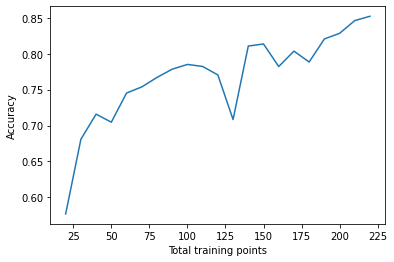

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(list(history.keys()), list(history.values()))
plt.xlabel("Total training points")
plt.ylabel("Accuracy");

In [19]:
# this time, try random acqusition
model.reset_weights()
ra_history = run_experiment(model, RandomAcquisition(),
                            X_train, y_train, X_pool, y_pool,
                            test_data_loader, optimiser, b=10,
                            iters=20, init_epochs=INITIAL_EPOCHS, epochs=EPOCHS,
                            device=device, batch_size=128, **dl_params)

Commencing initial training with 20 points
100%|██████████| 50/50 [00:06<00:00,  8.32it/s, loss=0.017]


/content/alr.py:163: UserWarning: Calling stochastic_forward but model is not in training mode. This may have unintended effects.
  warnings.warn('Calling stochastic_forward but '


Accuracy = 0.5583
=====
Acquisition iteration 1 (5.00%), training size: 30
100%|██████████| 50/50 [00:05<00:00,  8.35it/s, loss=0.0191]
Accuracy = 0.6254
=====
Acquisition iteration 2 (10.00%), training size: 40
100%|██████████| 50/50 [00:06<00:00,  7.93it/s, loss=0.0726]
Accuracy = 0.6517
=====
Acquisition iteration 3 (15.00%), training size: 50
100%|██████████| 50/50 [00:06<00:00,  7.86it/s, loss=0.0568]
Accuracy = 0.6821
=====
Acquisition iteration 4 (20.00%), training size: 60
100%|██████████| 50/50 [00:06<00:00,  7.74it/s, loss=0.0714]
Accuracy = 0.6957
=====
Acquisition iteration 5 (25.00%), training size: 70
100%|██████████| 50/50 [00:06<00:00,  7.87it/s, loss=0.102]
Accuracy = 0.7046
=====
Acquisition iteration 6 (30.00%), training size: 80
100%|██████████| 50/50 [00:06<00:00,  7.80it/s, loss=0.103]
Accuracy = 0.7491
=====
Acquisition iteration 7 (35.00%), training size: 90
100%|██████████| 50/50 [00:06<00:00,  7.78it/s, loss=0.102]
Accuracy = 0.7625
=====
Acquisition iteration

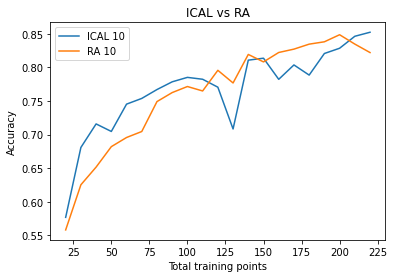

In [20]:
plt.plot(list(history.keys()), list(history.values()), label='ICAL 10')
plt.plot(list(ra_history.keys()), list(ra_history.values()), label='RA 10')
plt.xlabel("Total training points")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ICAL vs RA");